# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)


In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка данных

Будем использовать дефолтный текст ('text8'). Повторим простую предобработку текста из задания 2: удалим из текста стопслова и слишком редкие слова (встречающиеся менее 25 раз).
Также создадим батчер для SkipGram модели. Он генерирует батчи, состоящие из n пар слов (x, y), где x - центрально еслово, y - некоторое слово из окна вокруг центрального слова.

In [2]:
from preprocessing import prepare_data
frequent_words, token2id, id2token, batcher = prepare_data(min_count=25, shuffle=False)
print(f'Vocab size: {len(token2id)}')

Vocab size: 27790


Для генерации негативных примеров будем использовать распределение, предложенное в оригинальной статье (т.е. с возведением в степень 3/4).

In [3]:
import tensorflow_probability as tfp

In [4]:
total_counts = sum(map(lambda x: x**0.75, frequent_words.values()))
probs = [frequent_words[id2token[i]]**0.75 / total_counts for i in range(len(id2token))]

### Модель

In [5]:
class Word2VecNegativeSamplingModel():
    def __init__(self, params):
        self.embeddings = tf.get_variable(name='embedding_matrix', 
                                          shape=[params['vocab_size'], params['embedding_dim']], 
                                          dtype=tf.float32, 
                                          trainable=True)
        
        self.weights = tf.get_variable(name='weight_matrix', 
                                       shape=[params['vocab_size'], params['embedding_dim']], 
                                       trainable=True)
        
        self.negative_sampler = tfp.distributions.Categorical(probs=params['sample_probs'])
        
        self.inputs = tf.placeholder(shape=(None, 1), dtype=tf.int32, name='inputs')
        self.targets = tf.placeholder(shape=(None, 1), dtype=tf.int32, name='targets')
        self.learning_rate = tf.placeholder(shape=[], dtype=tf.float32, name='learning_rate')
        self.num_negatives = tf.placeholder(shape=[], dtype=tf.int32, name='num_negatives')
        
        batch_size = tf.shape(self.inputs)[0]
        self.negatives = self.negative_sampler.sample(sample_shape=(batch_size, self.num_negatives))
        self.targets_with_negatives = tf.concat([self.targets, self.negatives], axis=1)
        
        labels_positive = tf.ones_like(self.targets, dtype=tf.float32)
        labels_negative = tf.zeros_like(self.negatives, dtype=tf.float32)
        self.labels = tf.concat([labels_positive, labels_negative], axis=1)
        
        self.inputs_embedded = tf.nn.embedding_lookup(self.embeddings, self.inputs)
        self.current_weights = tf.transpose(tf.nn.embedding_lookup(self.weights, self.targets_with_negatives), perm=[0, 2, 1])
        
        self.logits = tf.squeeze(self.inputs_embedded @ self.current_weights)        
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
        self.loss_history = []
    
    def train(self, session, inputs, targets, learning_rate, num_negatives):
        feed_dict = {
            self.inputs: inputs, 
            self.targets: targets,
            self.learning_rate: learning_rate, 
            self.num_negatives: num_negatives
        }
    
        loss, _ = session.run([self.loss, self.train_op], feed_dict=feed_dict)
        
        return loss


In [6]:
def train_model(model, session, batcher, batch_size, num_epochs, learning_rate, num_negatives, loss_history, print_every=100):
    train_iter = int(np.ceil(len(batcher.data) / batch_size))
    print('Start training... \n')
    
    for epoch in range(1, num_epochs + 1):
        batcher.shuffle()
        
        print(f'Epoch {epoch}/{num_epochs}:')        
        epoch_loss = 0
        intermediate_loss = 0
        
        for i, (inputs, targets) in enumerate(batcher.generate_batches(batch_size=batch_size), 1):
            current_loss = model.train(session=session, 
                                       inputs=np.array(inputs).reshape(-1, 1), 
                                       targets=np.array(targets).reshape(-1, 1), 
                                       learning_rate=learning_rate, 
                                       num_negatives=num_negatives)
            
            epoch_loss += current_loss
            intermediate_loss += current_loss
            loss_history.append(current_loss)
            
            if i % print_every == 0 or (i == 1 and epoch == 1) or i == train_iter:
                if i == 1:
                    div = 1
                elif i == train_iter:
                    div = train_iter % print_every
                else:
                    div = print_every
                print(f'Epoch: [{epoch}/{num_epochs}], step: [{i}/{train_iter}], mean loss: {intermediate_loss / div}')
                if i != 1:
                    intermediate_loss = 0
        
        print(f'Epoch {epoch} finished, mean loss during epoch {epoch}: {epoch_loss / train_iter} \n')
    
    print('...training finished.')

In [7]:
def plot_loss(losses, average_over_batches=1, upper_bound=None):
    average_losses = [np.mean(losses[i:i+average_over_batches+1]) for i in range(0, len(losses), average_over_batches)]
    indices = list(range(average_over_batches, len(losses), average_over_batches)) + [len(losses)]
    plt.plot(indices, average_losses, '-')
    plt.grid(True)
    plt.title('Training loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    if upper_bound is not None:
        plt.ylim(top=upper_bound)
    plt.show()

### Обучение

Обучим word2vec модель с эмбеддингами размерности 50. Для каждого позитивного примера будем генерировать пять негативных.

In [8]:
params = {
    'embedding_dim': 50, 
    'vocab_size': len(token2id), 
    'sample_probs': probs
}

In [9]:
tf.reset_default_graph()
np.random.seed(111)
tf.set_random_seed(111)

In [10]:
model = Word2VecNegativeSamplingModel(params)

In [11]:
%%time

session = tf.Session()
session.run(tf.global_variables_initializer())

train_model(model=model, 
            session=session, 
            batcher=batcher, 
            num_epochs=3, 
            batch_size=2048, 
            learning_rate=1e-3, 
            num_negatives=5, 
            loss_history=model.loss_history, 
            print_every=3000)

Start training... 

Epoch 1/3:
Epoch: [1/3], step: [1/29334], mean loss: 0.6931509375572205
Epoch: [1/3], step: [3000/29334], mean loss: 0.44096336630980176
Epoch: [1/3], step: [6000/29334], mean loss: 0.40080486236015955
Epoch: [1/3], step: [9000/29334], mean loss: 0.3881560245056947
Epoch: [1/3], step: [12000/29334], mean loss: 0.38062996541460353
Epoch: [1/3], step: [15000/29334], mean loss: 0.37595944994688035
Epoch: [1/3], step: [18000/29334], mean loss: 0.37284892788529395
Epoch: [1/3], step: [21000/29334], mean loss: 0.3704303219020367
Epoch: [1/3], step: [24000/29334], mean loss: 0.3687258713245392
Epoch: [1/3], step: [27000/29334], mean loss: 0.36716091897090275
Epoch: [1/3], step: [29334/29334], mean loss: 0.3662474413227606
Epoch 1 finished, mean loss during epoch 1: 0.3835774409868092 

Epoch 2/3:
Epoch: [2/3], step: [3000/29334], mean loss: 0.36347351863980293
Epoch: [2/3], step: [6000/29334], mean loss: 0.3631399649679661
Epoch: [2/3], step: [9000/29334], mean loss: 0.362

Обучение в течение трех эпох заняло почти 4 часа на GTX 1050 Ti.

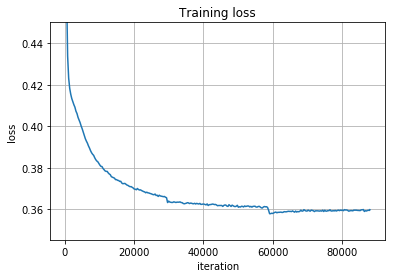

In [12]:
plot_loss(model.loss_history, average_over_batches=300, upper_bound=0.45)

Динамика лосса почти такая же, как и у моделей из предыдущих двух заданий.

In [16]:
embeddings = session.run(model.embeddings)
session.close()

### Оценка качества эмбеддингов

In [22]:
def get_embedding(token):
    '''Returns embedding for given token.'''
    
    return embeddings[token2id[token]]

def most_similar_to_embedding(input_embedding, embeddings, num_neighbors=10):
    '''Returns embeddings closest to given embedding measured by cosine similarity.'''
    
    distances = cosine_similarity(embeddings, input_embedding.reshape(1, -1)).reshape(-1)
    neighbor_indices = np.argpartition(distances, -num_neighbors-1)[-num_neighbors-1:]
    sorted_neighbor_indices = list(reversed(neighbor_indices[np.argsort(distances[neighbor_indices])]))
    return [id2token[idx] for idx in sorted_neighbor_indices[1:]]

def most_similar_to_token(token, embeddings, num_neighbors=10):
    '''Returns embeddings closest to embedding of given token measured by cosine similarity.'''
    
    return  most_similar_to_embedding(get_embedding(token), embeddings, num_neighbors)


Найдем самые близкие по косинусному расстоянию между эмбеддингами слова для слов fly, car, earth, computer, machine.

In [23]:
most_similar_to_token('fly', embeddings)

['airplane',
 'flies',
 'gliders',
 'glider',
 'pilot',
 'flight',
 'hover',
 'pilots',
 'crashed',
 'flying']

In [24]:
most_similar_to_token('car', embeddings)

['cars',
 'driver',
 'truck',
 'automobile',
 'motorcycle',
 'racing',
 'racer',
 'raced',
 'porsche',
 'mustang']

In [25]:
most_similar_to_token('earth', embeddings)

['planet',
 'interstellar',
 'planets',
 'umbra',
 'moon',
 'clouds',
 'cometary',
 'orbiting',
 'neptune',
 'heavens']

In [27]:
most_similar_to_token('computer', embeddings)

['computers',
 'computing',
 'hardware',
 'bootstrap',
 'firmware',
 'programmable',
 'hci',
 'robotics',
 'scanners',
 'microcomputers']

In [28]:
most_similar_to_token('machine', embeddings)

['machines',
 'programmable',
 'bootstrap',
 'bytecode',
 'portable',
 'computerized',
 'microprogram',
 'applesoft',
 'automatic',
 'operand']

Почти все полученные ближайшие соседи являются адекватными по смыслу.

Теперь попробуем получить корректные аналогии.

In [29]:
input_embedding = get_embedding('king') - get_embedding('man') + get_embedding('woman')
most_similar_to_embedding(input_embedding, embeddings)

['son',
 'highness',
 'isabella',
 'marries',
 'childless',
 'throne',
 'eldest',
 'daughter',
 'matilda',
 'reigned']

Классический пример с king - man + woman не сработал. Ничего похожего на queen среди ближайших соседей нет.

Однако, неокторые другие аналогии работают:

In [31]:
input_embedding = get_embedding('driver') - get_embedding('car') + get_embedding('airplane')
most_similar_to_embedding(input_embedding, embeddings)

['pilot',
 'driver',
 'fly',
 'flight',
 'boarded',
 'piloted',
 'otis',
 'wheelchair',
 'gunner',
 'interception']

driver - car + airplane = pilot

In [36]:
input_embedding = get_embedding('football') - get_embedding('europe') + get_embedding('america')
most_similar_to_embedding(input_embedding, embeddings)

['soccer',
 'basketball',
 'nhl',
 'baseball',
 'hockey',
 'rugby',
 'team',
 'softball',
 'bruins',
 'coached']

football - europe + america = soccer

In [39]:
input_embedding = get_embedding('nfl') - get_embedding('football') + get_embedding('hockey')
most_similar_to_embedding(input_embedding, embeddings)

['nhl',
 'nfc',
 'hockey',
 'afl',
 'cowboys',
 'colts',
 'rematch',
 'broncos',
 'browns',
 'playoffs']

NFL - football + hockey = NHL

In [40]:
input_embedding = get_embedding('nfl') - get_embedding('football') + get_embedding('basketball')
most_similar_to_embedding(input_embedding, embeddings)

['nba',
 'bengals',
 'cowboys',
 'colts',
 'texans',
 'chargers',
 'steelers',
 'phillies',
 'browns',
 'alcs']

NFL - football + basketball = NBA

Теперь выберем побольше слов и визуализируем их векторные представления с помощью t-SNE.

In [41]:
test_words = ['one', 'two', 'three', 'four', 'five', 
              'russia', 'germany', 'france', 'england', 'scotland', 'britain', 'china', 'japan', 'korea', 'india', 
              'moscow', 'berlin', 'paris', 'london', 'edinburgh',
              'car', 'truck', 'bus', 'train', 'airplane', 'plane', 'ship', 'yacht', 
              'human', 'man', 'woman', 'husband', 'wife', 'parents', 'son', 'daughter', 
              'good', 'great', 'fantastic', 'bad', 'awful', 
              'walk', 'run', 'swim', 'fly', 
              'game', 'sport', 'soccer', 'football', 'basketball', 'hockey', 'tennis', 
              'music', 'song', 'guitar', 'guitarist', 'drums', 'drummer', 'singer', 'vocalist', 
              'rock', 'metal', 'punk', 'rap', 'jazz', 'blues', 'pop', 
              'north', 'south', 'east', 'west']

test_word_embeddings = np.array([get_embedding(word) for word in test_words])
distance_matrix = 1 - np.round(cosine_similarity(test_word_embeddings), decimals=4)

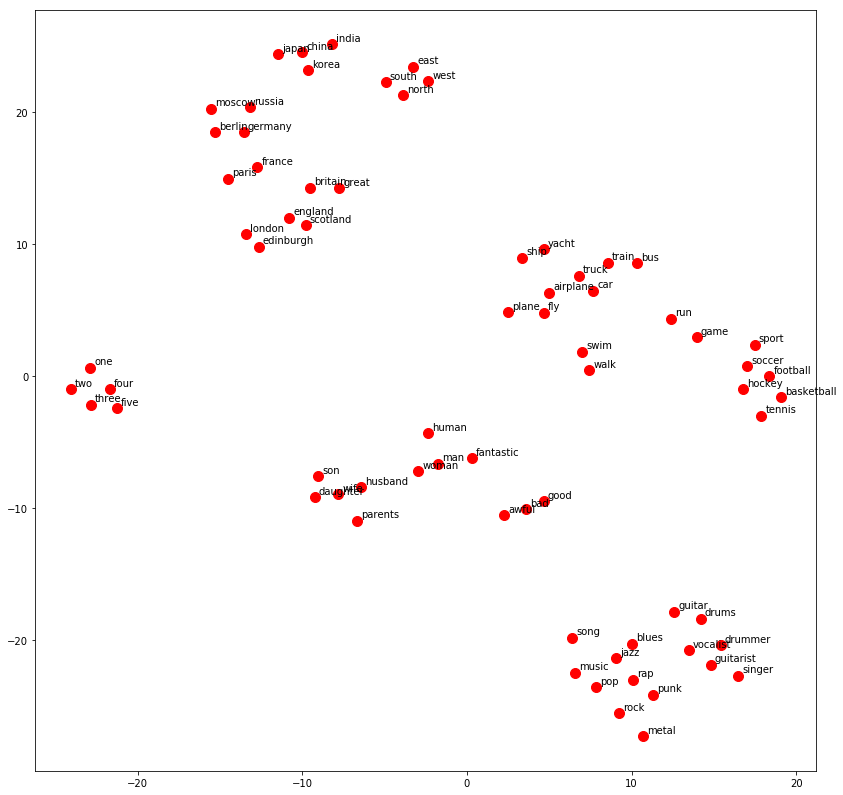

In [42]:
tsne = TSNE(perplexity=10, 
            early_exaggeration=10, 
            learning_rate=20, 
            n_iter=2000, 
            metric='precomputed', 
            method='exact', 
            random_state=100)

points = tsne.fit_transform(distance_matrix)

plt.figure(figsize=[14, 14])
plt.scatter(points[:, 0], points[:, 1], color='red', s=100)

indent = 0.25
for i in range(len(test_words)):
    coords = (points[i, 0] + indent, points[i, 1] + indent)
    plt.annotate(test_words[i], coords)

plt.show()

На визуализации слова разделились на ярко выраженные кластеры близких по смыслу слов: музыка, спорт, числа, страны и столицы...
Можно обратить внимание, что отношение страна-столица визуально получилось почти одинаковым для всех рассмотренных пар.

В целом, можно сделать вывод, что полученные эмбеддинги действительно содержат семантическую и синтаксическую информацию о словах.

Судя по рассмотренным примерам, качество эмбеддингов почти не отличаются от полученного в заданиях 3 и 4.

In [43]:
with open('embeddings_task5_part1.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. Поскольку эмбеддинги нормализованы, то скалярные произведения равны косинусным близостям. w - это просто матрица, содержащая эмбеддинги слов, находящихся в одном окне (т.е. идущих в тексте подряд). Таким образом, x - сумма попарных косинусных близостей слов, попавших в одно окно (с дополнительным вычетом единицы). b - это матрица, содержащая эмбеддинги слов, взятых из рахных окон (т.е., скорее всего, находящихся далеко друг от друга в тексте). Поэтому y - сумма попарных косинусных близостей слов, взятых из рахных окон. Значит, если мы минимизируем лосс вида loss = -x + y, то мы максимизируем косинусную близость эмбеддингов для слов, взятых из одного окна, и минимизируем косинусную близость для слов, взятых из разных окон.
  1. Какие-то концептуальные модификации, кажется, не нужны, однако для ускорения вычислений нужно заменить оба цикла на матричные операции. Я также прибаляю единицу к каждой косинсуной близости, входящей в y: это не влияет на оптимизационную задачу, но гарантирует, что лосс будет принимать неотрицательные значения.
  1. В данной формуле мы считаем все попарные косинусные расстояния слов, попавших в одно окно, а значит, какое-либо различие между центральными/внутренними и контекстными/внешними словами пропадает. Поэтому лично я бы не стал интерпретировать ее ни как skip-gram, ни как CBOW модель. 
  1. В случае batch-transpose trick мы предполагаем, что слова из разных окон должны быть непохожи друг на друга, а потому важно, чтобы в один батч не попадали окна, находящиеся близко в тексте. Но при достаточно большом корпусе это условие будет выполняться с достаточно высокой вероятностью при обычном случайном сэмплировании окон для батча.

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Повторим ту же предобработку текста, что и раньше. Однако, здесь будем использовать другой батчер: он генерирует батчи, состоящие из последовательностей подряд идущих слов длины $2 * window\_size + 1$.

In [2]:
from preprocessing import *
frequent_words, token2id, id2token, batcher = prepare_data(min_count=25, batcher=BatchTransposeTrickBatcher, shuffle=False)

In [3]:
class Word2VecBatchTransposeTrickModel():
    def __init__(self, params):
        self.embeddings = tf.get_variable(name='embedding_matrix', 
                                          shape=[params['vocab_size'], params['embedding_dim']], 
                                          dtype=tf.float32, 
                                          trainable=True)
        
        self.inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='inputs')
        self.learning_rate = tf.placeholder(shape=[], dtype=tf.float32, name='learning_rate')
        
        self.inputs_embedded = tf.math.l2_normalize(tf.nn.embedding_lookup(self.embeddings, self.inputs), axis=-1)
        
        x = self.inputs_embedded @ tf.transpose(self.inputs_embedded, perm=(0, 2, 1)) - 1
        y = tf.transpose(self.inputs_embedded, perm=(1, 0, 2)) @ tf.transpose(self.inputs_embedded, perm=(1, 2, 0)) + 1
        self.loss = -tf.reduce_mean(x) + tf.reduce_mean(y)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
        self.loss_history = []
    
    def train(self, session, inputs, learning_rate):
        feed_dict = {
            self.inputs: inputs, 
            self.learning_rate: learning_rate, 
        }
    
        loss, _ = session.run([self.loss, self.train_op], feed_dict=feed_dict)
        
        return loss

In [4]:
def train_model(model, session, batcher, batch_size, num_epochs, learning_rate, num_negatives, loss_history, print_every=100):
    train_iter = int(np.ceil(len(batcher.data) / batch_size))
    print('Start training... \n')
    
    for epoch in range(1, num_epochs + 1):
        batcher.shuffle()
        
        print(f'Epoch {epoch}/{num_epochs}:')        
        epoch_loss = 0
        intermediate_loss = 0
        
        for i, inputs in enumerate(batcher.generate_batches(batch_size=batch_size), 1):
            current_loss = model.train(session=session, 
                                       inputs=inputs, 
                                       learning_rate=learning_rate)
            
            epoch_loss += current_loss
            intermediate_loss += current_loss
            loss_history.append(current_loss)
            
            if i % print_every == 0 or (i == 1 and epoch == 1) or i == train_iter:
                if i == 1:
                    div = 1
                elif i == train_iter:
                    div = train_iter % print_every
                else:
                    div = print_every
                print(f'Epoch: [{epoch}/{num_epochs}], step: [{i}/{train_iter}], mean loss: {intermediate_loss / div}')
                if i != 1:
                    intermediate_loss = 0
        
        print(f'Epoch {epoch} finished, mean loss during epoch {epoch}: {epoch_loss / train_iter} \n')
    
    print('...training finished.')

In [5]:
def plot_loss(losses, average_over_batches=1, upper_bound=None):
    average_losses = [np.mean(losses[i:i+average_over_batches+1]) for i in range(0, len(losses), average_over_batches)]
    indices = list(range(average_over_batches, len(losses), average_over_batches)) + [len(losses)]
    plt.plot(indices, average_losses, '-')
    plt.grid(True)
    plt.title('Training loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    if upper_bound is not None:
        plt.ylim(top=upper_bound)
    plt.show()

In [6]:
params = {
    'embedding_dim': 50, 
    'vocab_size': len(token2id),  
}

In [7]:
tf.reset_default_graph()
np.random.seed(111)
tf.set_random_seed(111)

In [8]:
model = Word2VecBatchTransposeTrickModel(params)

In [9]:
%%time

session = tf.Session()
session.run(tf.global_variables_initializer())

train_model(model=model, 
            session=session, 
            batcher=batcher, 
            num_epochs=3, 
            batch_size=512, 
            learning_rate=1e-3, 
            num_negatives=5, 
            loss_history=model.loss_history, 
            print_every=3000)

Start training... 

Epoch 1/3:
Epoch: [1/3], step: [1/19556], mean loss: 1.846848487854004
Epoch: [1/3], step: [3000/19556], mean loss: 1.5393444976409276
Epoch: [1/3], step: [6000/19556], mean loss: 1.5245565182367962
Epoch: [1/3], step: [9000/19556], mean loss: 1.5234688791036606
Epoch: [1/3], step: [12000/19556], mean loss: 1.5225843135515849
Epoch: [1/3], step: [15000/19556], mean loss: 1.5220684513250986
Epoch: [1/3], step: [18000/19556], mean loss: 1.522691804965337
Epoch: [1/3], step: [19556/19556], mean loss: 1.5216099531760865
Epoch 1 finished, mean loss during epoch 1: 1.525453491593997 

Epoch 2/3:
Epoch: [2/3], step: [3000/19556], mean loss: 1.5211596020857494
Epoch: [2/3], step: [6000/19556], mean loss: 1.5212981861035029
Epoch: [2/3], step: [9000/19556], mean loss: 1.5222860403855643
Epoch: [2/3], step: [12000/19556], mean loss: 1.5216472469568252
Epoch: [2/3], step: [15000/19556], mean loss: 1.5211781853834787
Epoch: [2/3], step: [18000/19556], mean loss: 1.5209977134466

Обучение проходит в разы быстрее, однако лосс падает только в самом начала первой эпохи, а затем практически не изменяется.

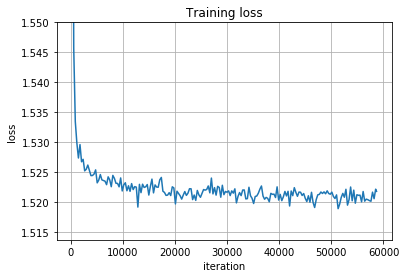

In [10]:
plot_loss(model.loss_history, average_over_batches=300, upper_bound=1.55)

In [11]:
embeddings = session.run(model.embeddings)

### Оценка качества эмбеддингов

In [12]:
def get_embedding(token):
    '''Returns embedding for given token.'''
    
    return embeddings[token2id[token]]

def most_similar_to_embedding(input_embedding, embeddings, num_neighbors=10):
    '''Returns embeddings closest to given embedding measured by cosine similarity.'''
    
    distances = cosine_similarity(embeddings, input_embedding.reshape(1, -1)).reshape(-1)
    neighbor_indices = np.argpartition(distances, -num_neighbors-1)[-num_neighbors-1:]
    sorted_neighbor_indices = list(reversed(neighbor_indices[np.argsort(distances[neighbor_indices])]))
    return [id2token[idx] for idx in sorted_neighbor_indices[1:]]

def most_similar_to_token(token, embeddings, num_neighbors=10):
    '''Returns embeddings closest to embedding of given token measured by cosine similarity.'''
    
    return  most_similar_to_embedding(get_embedding(token), embeddings, num_neighbors)


Найдем самые близкие по косинусному расстоянию между эмбеддингами слова для слов fly, car, earth, computer, machine.

In [13]:
most_similar_to_token('fly', embeddings)

['catches',
 'flies',
 'cranes',
 'gold',
 'glider',
 'red',
 'turtle',
 'abort',
 'deck',
 'hog']

In [14]:
most_similar_to_token('car', embeddings)

['cap',
 'flint',
 'tickets',
 'engined',
 'jumper',
 'centimetres',
 'auto',
 'sprint',
 'motorcycle',
 'redesigned']

In [15]:
most_similar_to_token('earth', embeddings)

['horizon',
 'smoke',
 'clouds',
 'foam',
 'stew',
 'elapsed',
 'bows',
 'inside',
 'fused',
 'boil']

In [16]:
most_similar_to_token('computer', embeddings)

['debugger',
 'directx',
 'mirc',
 'lambda',
 'archaeopteryx',
 'developers',
 'mng',
 'mdi',
 'files',
 'filename']

In [17]:
most_similar_to_token('machine', embeddings)

['crt',
 'homeomorphic',
 'shell',
 'stellar',
 'slice',
 'checksum',
 'equivalently',
 'transformer',
 'waveform',
 'sequentially']

Среди ближайших соседей меньше половины (иногда сильно меньше) являются релевантными по смыслу.

При этом вполне ожидаемо, что аналогии почти совсем не работают:

In [18]:
input_embedding = get_embedding('king') - get_embedding('man') + get_embedding('woman')
most_similar_to_embedding(input_embedding, embeddings)

['christened',
 'consort',
 'ulysses',
 'celebrates',
 'honor',
 'grandson',
 'thirteen',
 'paine',
 'alexander',
 'sancho']

In [19]:
input_embedding = get_embedding('driver') - get_embedding('car') + get_embedding('airplane')
most_similar_to_embedding(input_embedding, embeddings)

['anaconda',
 'crash',
 'mays',
 'ham',
 'yard',
 'seconds',
 'lifes',
 'rush',
 'driver',
 'softball']

In [20]:
input_embedding = get_embedding('nfl') - get_embedding('football') + get_embedding('hockey')
most_similar_to_embedding(input_embedding, embeddings)

['sportsman',
 'hockey',
 'racer',
 'doubles',
 'lbs',
 'sedan',
 'nhl',
 'davidson',
 'brewers',
 'shutout']

Здесь NHL все же попал в top-10.

Визуализируем векторные представления слов с помощью t-SNE.

In [21]:
test_words = ['one', 'two', 'three', 'four', 'five', 
              'russia', 'germany', 'france', 'england', 'scotland', 'britain', 'china', 'japan', 'korea', 'india', 
              'moscow', 'berlin', 'paris', 'london', 'edinburgh',
              'car', 'truck', 'bus', 'train', 'airplane', 'plane', 'ship', 'yacht', 
              'human', 'man', 'woman', 'husband', 'wife', 'parents', 'son', 'daughter', 
              'good', 'great', 'fantastic', 'bad', 'awful', 
              'walk', 'run', 'swim', 'fly', 
              'game', 'sport', 'soccer', 'football', 'basketball', 'hockey', 'tennis', 
              'music', 'song', 'guitar', 'guitarist', 'drums', 'drummer', 'singer', 'vocalist', 
              'rock', 'metal', 'punk', 'rap', 'jazz', 'blues', 'pop', 
              'north', 'south', 'east', 'west']

test_word_embeddings = np.array([get_embedding(word) for word in test_words])
distance_matrix = 1 - np.round(cosine_similarity(test_word_embeddings), decimals=4)

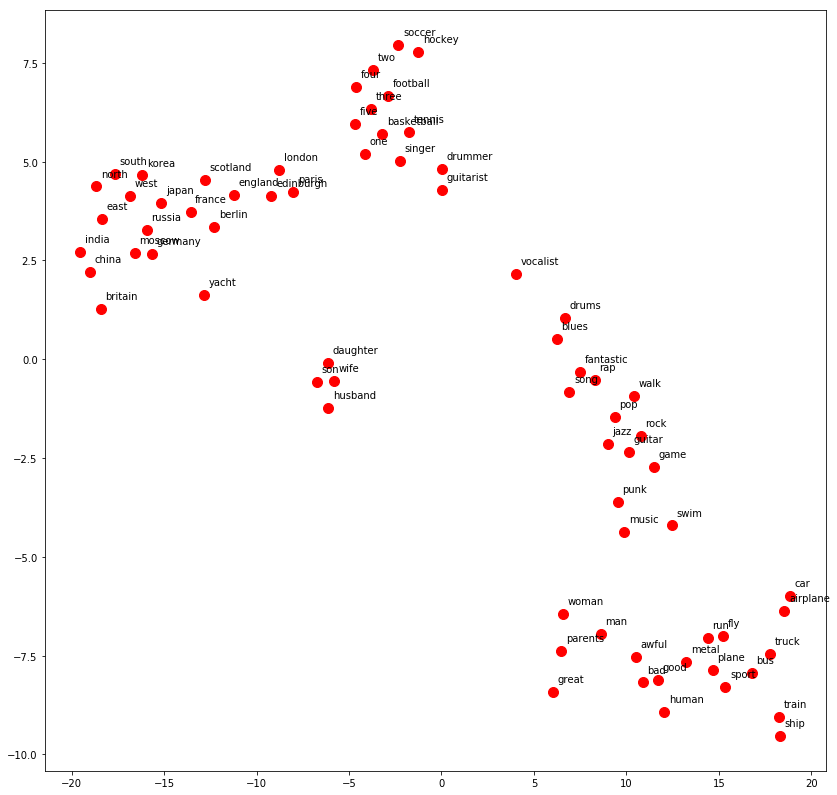

In [22]:
tsne = TSNE(perplexity=10, 
            early_exaggeration=10, 
            learning_rate=20, 
            n_iter=2000, 
            metric='precomputed', 
            method='exact', 
            random_state=111)

points = tsne.fit_transform(distance_matrix)

plt.figure(figsize=[14, 14])
plt.scatter(points[:, 0], points[:, 1], color='red', s=100)

indent = 0.25
for i in range(len(test_words)):
    coords = (points[i, 0] + indent, points[i, 1] + indent)
    plt.annotate(test_words[i], coords)

plt.show()

На визуализации слова разбиваются на кластеры по темам (спорт, музыка, страны и города...), однако кластеры гораздо хуже разделены, чем в предыдущем случае, а некоторые и вовсе почти сливаются.

Таким образом, модель позволяет очень бысто получить эмбеддинги среднего качества, но не может далее их улучшить.

В целом, эмбеддинги, полученные с помощью batch-transpose trick, значительно уступают полученным с помощью negative sampling (а последние оказались такими же по качетсву, что и полученные с помощью модели с softmax выходным слоем из предыддущих заданий).

In [23]:
with open('embeddings_task5_part2.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle)